In [ ]:
import numpy as np
import math
from math import pi
import torch
from matplotlib import pyplot as plt
from torch.distributions import MultivariateNormal

In [ ]:
torch.manual_seed(256)
torch.set_printoptions(precision=5, linewidth=140)

In [ ]:
n_clusters = 6
n_samples= 250

In [ ]:
centroids = torch.randn(n_clusters, 2) * 70 - 35

In [ ]:
def sample(c): return MultivariateNormal(c, torch.diag(torch.tensor([5., 5.]))).sample((n_samples,))

In [ ]:
data = torch.concat([sample(c) for c in centroids], axis=0)

In [ ]:
data.shape

torch.Size([1500, 2])

In [ ]:
def plot_data(centroids, data, ax=None):
    if ax is None: fig, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], s = 1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color="m", mew=3)

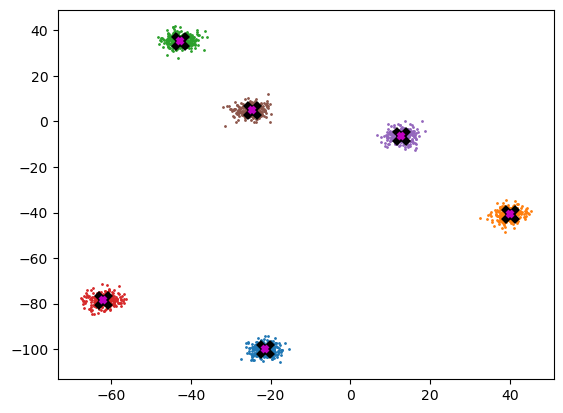

In [ ]:
plot_data(centroids, data)

In [ ]:
def gaussian(dist, bw=2.5): return (1/(math.sqrt(2*pi)*bw))*np.exp(-0.5*(dist/bw)**2)

[<matplotlib.lines.Line2D>]

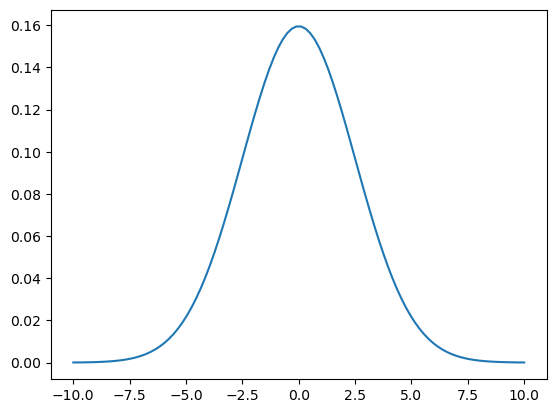

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(-10, 10, 100)
ax.plot(x, gaussian(x))

In [ ]:
X = data[:8]

In [ ]:
x = X[0]

In [ ]:
gaussian(((x - X)**2).sum(1).sqrt()).shape

torch.Size([8])

In [ ]:
dist = ((x - X)**2).sum(1).sqrt()

In [ ]:
dist.sort().values[:300]

tensor([0.00000, 2.51033, 2.76326, 3.63269, 4.76265, 6.55409, 7.63412, 7.69975])

In [ ]:
def one_update(X):
    for i, x in enumerate(X):
        dist = ((x - X)**2).sum(1).sqrt()
        weight = gaussian(dist, bw=2.5)
        X[i] = (weight[..., None] * X).sum(0)/weight.sum(0)

In [ ]:
def meanshift(data):
    X = data.clone()
    for i in range(5): one_update(X)
    return X

In [ ]:
X= meanshift(data)

In [ ]:
X

tensor([[ -21.54807, -100.08532],
        [ -21.54807, -100.08532],
        [ -21.54807, -100.08532],
        ...,
        [ -24.87562,    5.00367],
        [ -24.87562,    5.00366],
        [ -24.87562,    5.00366]])

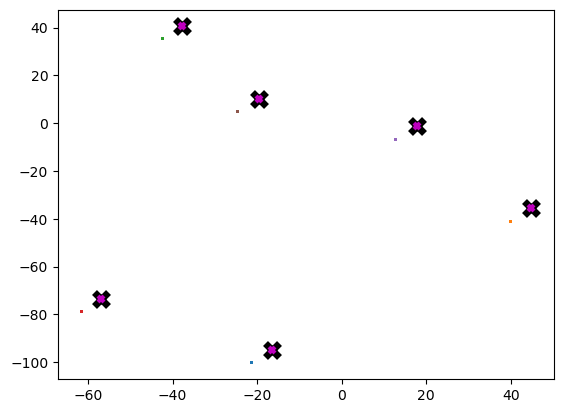

In [ ]:
plot_data(centroids+5, X)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def animate(d):
    if not d: return plot_data(centroids + 5, X, ax=ax)
    one_update(X)
    ax.clear()
    plot_data(centroids + 5, X, ax=ax)

In [ ]:
X= data.clone()
fig, ax = plt.subplots()
f = FuncAnimation(fig, animate, frames=5, interval=500, repeat=False)
plt.close()
HTML(f.to_jshtml())